# CATE estimators example

In [2]:
import pyspark.sql.functions as F
import pysparkling
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from upliftml.models.h2o import (
    SLearnerEstimator,
    TLearnerEstimator,
    CVTEstimator,
    TransformedOutcomeEstimator,
    XLearnerEstimator,
    RLearnerEstimator
)
from upliftml.evaluation import (
    estimate_ate,
    estimate_and_plot_cate_per_bucket,
    estimate_and_plot_cate_per_quantile,
    estimate_and_plot_cate_lift,
    estimate_and_plot_qini
)
from upliftml.datasets import simulate_randomized_trial

### Start H2O

In [ ]:
context = pysparkling.H2OContext.getOrCreate()

### Specify plot style

In [4]:
sns.set(font_scale=1.5, style='ticks', rc={'figure.figsize':(11, 7)})

### Read dataframe

In [5]:
df_pd = simulate_randomized_trial(n=2000, p=6, sigma=1.0, binary_outcome=True)
df_spark = spark.createDataFrame(df_pd)

In [6]:
df_spark.cache().count()

2000

In [7]:
df_spark.limit(5).toPandas()

,treatment,outcome,propensity,expected_outcome,actual_cate,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
0,0,1,0.5,0.658707,-0.457127,-2.285505,-1.439856,-1.554759,-0.282395,0.941101,-0.879649
1,1,1,0.5,1.347520,0.046786,1.001404,0.755385,-0.409268,-0.715676,0.220544,0.422432
2,0,0,0.5,0.297256,0.356870,0.533959,-0.171249,-0.065454,-1.226980,0.754708,-2.471411
3,0,1,0.5,0.000000,-0.455912,-0.444909,-0.746554,0.060087,-1.217604,0.705201,0.050834
4,0,1,0.5,1.547923,-0.235872,-1.453316,2.207736,0.504080,0.281325,0.008098,0.667075


### Estimate overall ATE

In [8]:
target_col = 'outcome'

results = estimate_ate(df_spark,
                       target_colname=target_col,
                       bootstrap=True,
                       n_bootstraps=300,
                       ci_quantiles=[0.025, 0.975])

print('{} rate control: {:.4f}, lower: {:.4f}, upper: {:.4f}'.format(target_col, results['target_rate_control'], results['target_rate_control_lower'], results['target_rate_control_upper']))
print('{} rate treated: {:.4f}, lower: {:.4f}, upper: {:.4f}'.format(target_col, results['target_rate_treated'], results['target_rate_treated_lower'], results['target_rate_treated_upper']))
print('{} ATE: {:.4f}, lower: {:.4f}, upper: {:.4f}'.format(target_col, results['ate'], results['ate_lower'], results['ate_upper']))
print('')

outcome rate control: 0.7300, lower: 0.7011, upper: 0.7558
outcome rate treated: 0.7963, lower: 0.7714, upper: 0.8203
outcome ATE: 0.0663, lower: 0.0279, upper: 0.1064



### Exploratory analysis

#### Plot CATE by bucket, based on categories from a categorical feature

In [9]:
# Add a categorical feature 'bucket'
df_spark_with_bucket = df_spark.withColumn('bucket', F.col('feature_1').cast('int'))

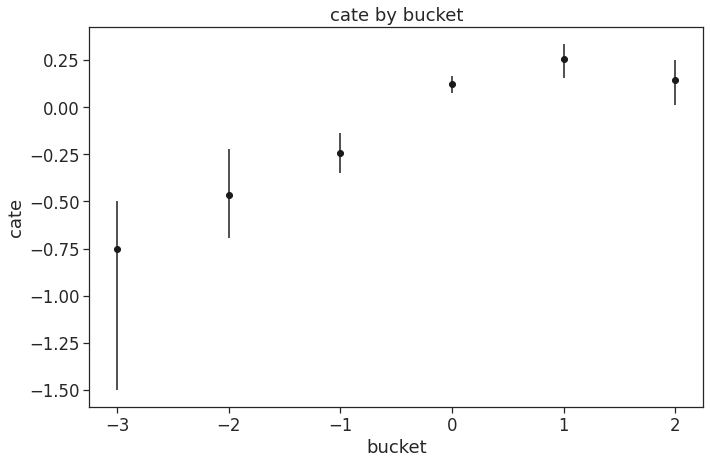

In [10]:
df_barplot, ax = estimate_and_plot_cate_per_bucket(df_spark_with_bucket, 
                                                  bucket_colname='bucket', 
                                                  target_colname='outcome',
                                                  bootstrap=True, 
                                                  n_bootstraps=300)

#### Generate buckets based on quantiles and plot CATE by bucket

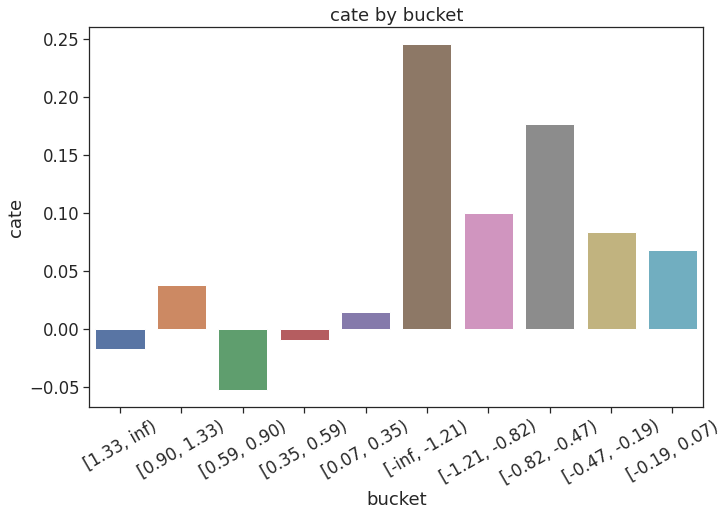

In [11]:
df_cate, ax = estimate_and_plot_cate_per_quantile(df_spark, 
                                    n_buckets=10, 
                                    score_colname='feature_3', 
                                    target_colname='outcome', 
                                    add_labels=True,
                                    sort_x=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);

### Train CATE estimators

#### Convert Spark dataframe into H2O

In [12]:
df_h2o = context.asH2OFrame(df_spark, h2oFrameName = 'df_h2o')

#### Train/Validation/Test Split

In [13]:
df_h2o_train, df_h2o_val, df_h2o_test = df_h2o.split_frame([0.50, 0.25])

#### Define parameters

In [14]:
base_model_class = H2OGeneralizedLinearEstimator

model_params_cls = {'family': 'binomial'}
model_params_reg = {'family': 'gaussian'}

predictor_colnames = [col for col in df_spark.columns if col.startswith('feature')]

#### Initialize Estimators

In [15]:
slearner_estimator = SLearnerEstimator(base_model_class, 
                                       model_params_cls, 
                                       predictor_colnames, 
                                       target_colname='outcome', 
                                       treatment_colname='treatment', 
                                       categorical_outcome=True, 
                                       output_colname='cate_s')

tlearner_estimator = TLearnerEstimator(base_model_class, 
                                       model_params_cls, 
                                       predictor_colnames, 
                                       target_colname='outcome', 
                                       treatment_colname='treatment', 
                                       categorical_outcome=True, 
                                       output_colname='cate_t')

cvt_estimator = CVTEstimator(base_model_class, 
                             model_params_cls, 
                             predictor_colnames, 
                             target_colname='outcome', 
                             treatment_colname='treatment', 
                             output_colname='cate_cvt')

transformed_outcome_estimator = TransformedOutcomeEstimator(base_model_class, 
                                                            model_params_reg, 
                                                            predictor_colnames, 
                                                            target_colname='outcome', 
                                                            treatment_colname='treatment', 
                                                            output_colname='cate_to')

xlearner_estimator = XLearnerEstimator(base_model_class_1=base_model_class,
                                       base_model_params_1=model_params_cls,
                                       predictor_colnames_1=predictor_colnames,
                                       base_model_class_2=base_model_class,
                                       base_model_params_2=model_params_reg,
                                       predictor_colnames_2=predictor_colnames,
                                       target_colname='outcome',
                                       treatment_colname='treatment',
                                       categorical_outcome=True,
                                       output_colname='cate_x')

rlearner_estimator = RLearnerEstimator(target_model_class=base_model_class,
                                       target_model_params=model_params_cls,
                                       final_model_class=base_model_class,
                                       final_model_params=model_params_reg,
                                       predictor_colnames=predictor_colnames,
                                       target_colname='outcome',
                                       treatment_colname='treatment',
                                       categorical_outcome=True,
                                       n_folds=5,
                                       output_colname='cate_r')

#### Train the Estimators and add predicted scores

In [16]:
rlearner_estimator.fit(df_h2o_train, df_h2o_val)
transformed_outcome_estimator.fit(df_h2o_train, df_h2o_val)
xlearner_estimator.fit(df_h2o_train, df_h2o_val)
slearner_estimator.fit(df_h2o_train, df_h2o_val)
tlearner_estimator.fit(df_h2o_train, df_h2o_val)
cvt_estimator.fit(df_h2o_train, df_h2o_val)

glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Model Build progress: |█

In [17]:
eval_colnames = ['treatment', 'outcome']

In [18]:
df_h2o_test_eval = (
    df_h2o_test[eval_colnames]
    .cbind(slearner_estimator.predict(df_h2o_test))
    .cbind(tlearner_estimator.predict(df_h2o_test))
    .cbind(cvt_estimator.predict(df_h2o_test))
    .cbind(transformed_outcome_estimator.predict(df_h2o_test))
    .cbind(xlearner_estimator.predict(df_h2o_test))
    .cbind(rlearner_estimator.predict(df_h2o_test))
)

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [19]:
df_spark_test_eval = context.asSparkFrame(df_h2o_test_eval)

### Evaluate

In [20]:
df_spark_test_eval.limit(10).toPandas()

,treatment,outcome,cate_s,cate_t,cate_cvt,cate_to,cate_x,cate_r
0,0,0,0.072950,0.127014,0.032612,-0.102331,0.056789,0.067916
1,0,1,0.035301,0.048821,0.093402,0.243918,-0.029013,-0.065350
2,1,1,0.031370,0.261594,0.367107,0.240630,0.403392,0.431978
3,1,1,0.099526,-0.172871,-0.169531,-0.278874,-0.076403,-0.032081
4,1,1,0.088966,-0.116676,-0.155757,-0.257938,-0.083457,-0.068394
5,0,1,0.017551,0.093683,0.146052,0.016563,0.226820,0.244042
6,0,1,0.095166,-0.403232,-0.210364,-0.148163,-0.204896,-0.176689
7,1,1,0.026384,0.115916,0.170159,0.092067,0.182338,0.153487
8,1,1,0.083511,0.315309,0.191409,0.229053,0.219758,0.207578
9,1,1,0.014361,0.041987,0.047880,0.013573,0.061445,0.059767


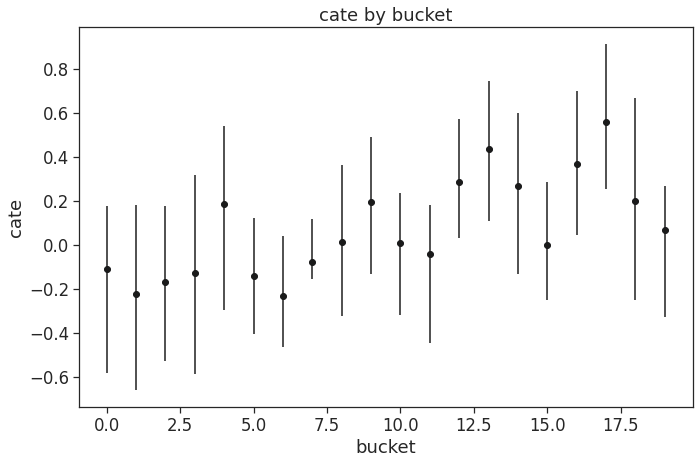

In [21]:
df_barplot, ax = estimate_and_plot_cate_per_quantile(df_spark_test_eval, 
                                                    n_buckets=20, 
                                                    score_colname='cate_t',
                                                    target_colname='outcome', 
                                                    bootstrap=True, 
                                                    n_bootstraps=100)

#### CATE lift

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


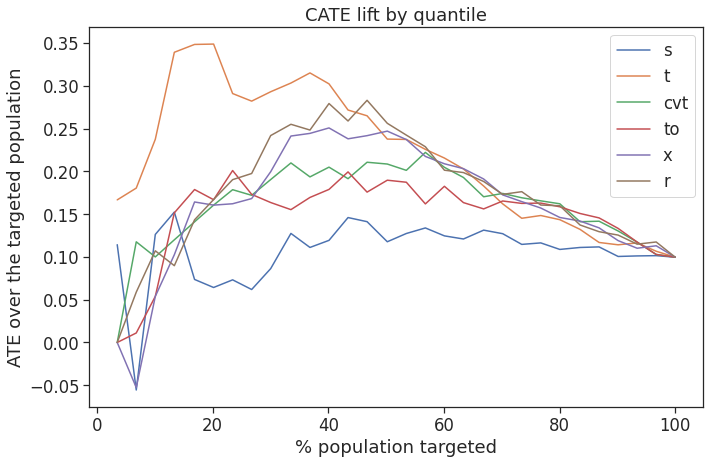

In [22]:
for model_name in ['s', 't', 'cvt', 'to', 'x', 'r']:
    estimate_and_plot_cate_lift(df_spark_test_eval, 
                               score_colname=f'cate_{model_name}', 
                               target_colname='outcome', 
                               label=model_name)

FixedFormatter should only be used together with FixedLocator


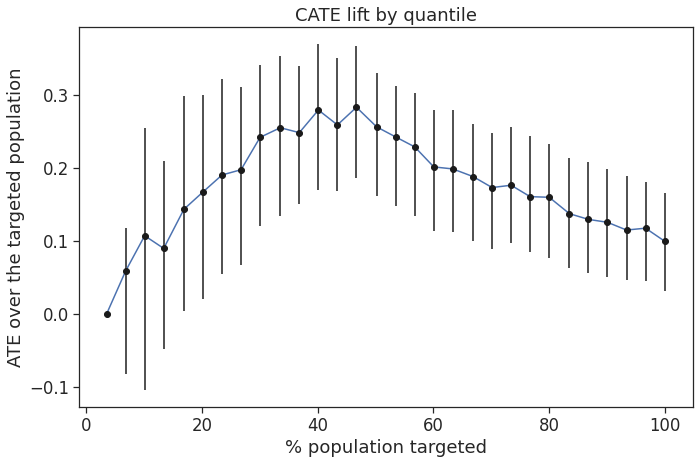

In [23]:
# with bootstrapping
_, _ = estimate_and_plot_cate_lift(df_spark_test_eval, 
                                  score_colname='cate_r', 
                                  target_colname='outcome', 
                                  bootstrap=True, 
                                  n_bootstraps=100)

#### Qini

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


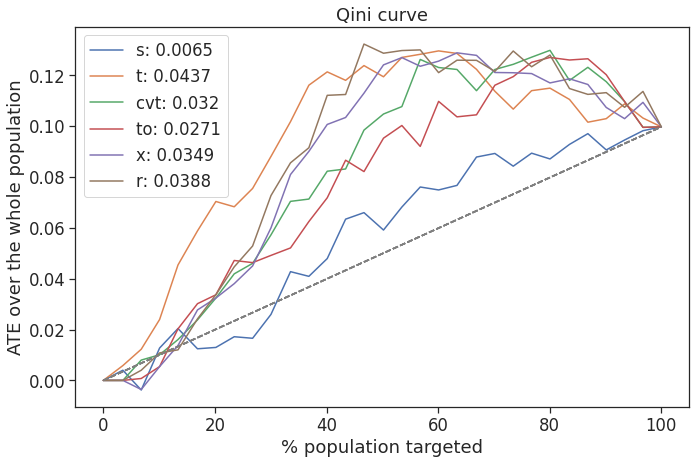

In [24]:
for model_name in ['s', 't', 'cvt', 'to', 'x', 'r']:
    estimate_and_plot_qini(df_spark_test_eval, 
                          score_colname=f'cate_{model_name}', 
                          target_colname='outcome', 
                          label=model_name)

FixedFormatter should only be used together with FixedLocator


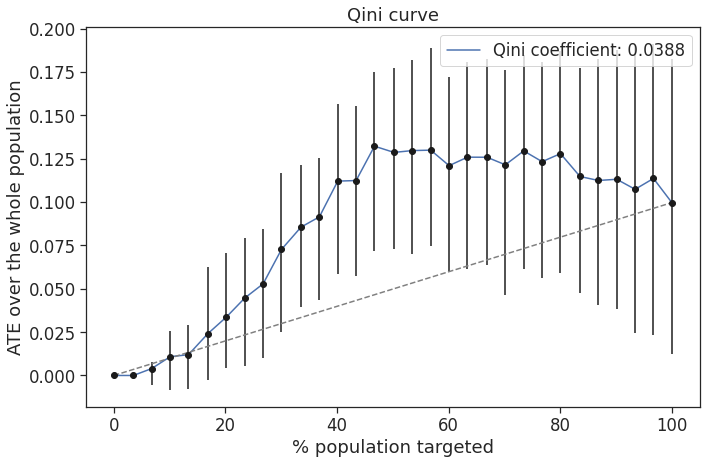

In [25]:
# with bootstrapping
_, _ = estimate_and_plot_qini(df_spark_test_eval, 
                             score_colname='cate_r', 
                             target_colname='outcome', 
                             bootstrap=True, 
                             n_bootstraps=100)

#### Plotting with subplots

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


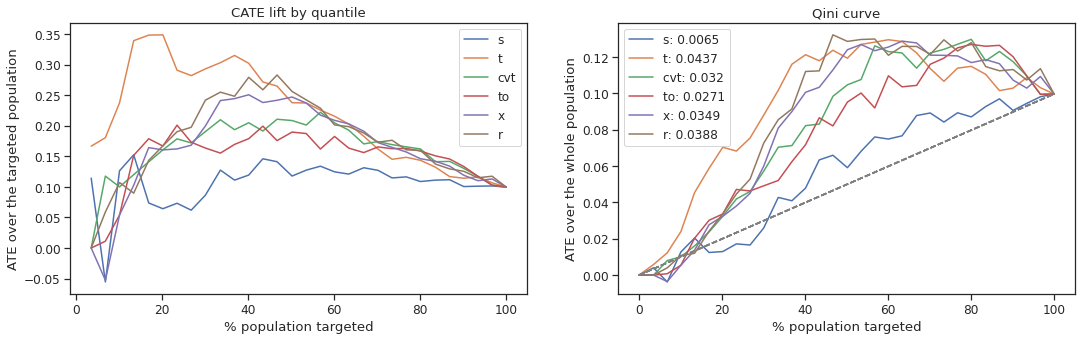

In [26]:
sns.set(font_scale=1.1, style='ticks', rc={'figure.figsize':(18, 5)})

fig, axes = plt.subplots(1, 2)

for model_name in ['s', 't', 'cvt', 'to', 'x', 'r']:
    estimate_and_plot_cate_lift(df_spark_test_eval, 
                               score_colname=f'cate_{model_name}', 
                               target_colname='outcome', 
                               label=model_name,
                               ax=axes[0])
    
for model_name in ['s', 't', 'cvt', 'to', 'x', 'r']:
    estimate_and_plot_qini(df_spark_test_eval, 
                          score_colname=f'cate_{model_name}', 
                          target_colname='outcome', 
                          label=model_name,
                          ax=axes[1])

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


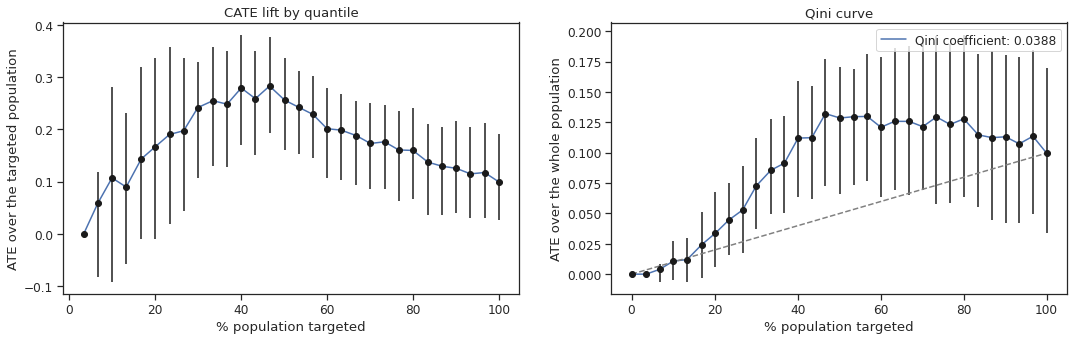

In [27]:
sns.set(font_scale=1.1, style='ticks', rc={'figure.figsize':(18, 5)})

fig, axes = plt.subplots(1, 2)

_, _ = estimate_and_plot_cate_lift(df_spark_test_eval, 
                                  score_colname='cate_r', 
                                  target_colname='outcome', 
                                  bootstrap=True, 
                                  n_bootstraps=100,
                                  ax=axes[0])
    
_, _ = estimate_and_plot_qini(df_spark_test_eval, 
                             score_colname='cate_r', 
                             target_colname='outcome', 
                             bootstrap=True, 
                             n_bootstraps=100,
                             ax=axes[1])